# Segmentação de textos

Esse código é parte do trabalho final do aluno Matheus Stauffer Viana de Oliveira, 16/0071852, da disciplina de Estudos em Inteligência Artificial, ministrada pela professora Drª Roberta Barbosa Oliveira.

O problema tratado é a segmentação de textos, com uma modelagem usando reconhecimento de entidades nomeadas em conjunto com classificação de texto.

## Reconhecimento de entidades nomeadas

Será usada a base KnEDLe de atos de pessoal, https://github.com/UnB-KnEDLe/datasets/blob/master/anotacoes_atos_de_pessoal.md.

Os dados serão rotulados no formato IOB com 4 classes:
1. B-Inicio
2. I-Inicio
3. B-FIM
4. O

O objetivo é identificar os tokens que demarcam o começo e o final dos atos de pessoal.

### Pré-processamento IOB

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/dodf_atos_pessoal_v3.csv')
df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93897 entries, 0 to 93896
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id_ato         93897 non-null  object
 1   id_dodf        93897 non-null  object
 2   num_doc_dodf   93897 non-null  int64 
 3   data_doc_dodf  93897 non-null  object
 4   tipo_rel       93897 non-null  object
 5   id_rel         93897 non-null  object
 6   anotador_rel   93897 non-null  object
 7   texto_rel      93897 non-null  object
 8   tipo_ent       93897 non-null  object
 9   id_ent         93897 non-null  int64 
 10  anotador_ent   93897 non-null  object
 11  texto_ent      93897 non-null  object
dtypes: int64(2), object(10)
memory usage: 8.6+ MB


Filtro de entidades de atos inteiros

In [ ]:
df_atos = df.loc[df['tipo_ent'].str.contains('Ato_')]
df_atos = df_atos.reset_index(drop=True)

In [ ]:
df_atos.tipo_rel.value_counts()

Ato_Substituicao                  2404
Ato_Exoneracao_Comissionado       2372
Ato_Nomeacao_Comissionado         2316
Ato_Retificacao_Efetivo           1196
Ato_Exoneracao_Efetivo             303
Ato_Cessao                         266
Ato_Retificacao_Comissionado       264
Ato_Tornado_Sem_Efeito_Exo_Nom     253
Ato_Abono_Permanencia              137
Ato_Nomeacao_Efetivo                82
Ato_Reversao                        67
Ato_Tornado_Sem_Efeito_Apo          19
Name: tipo_rel, dtype: int64

Identificando DODFs com mais tipos diferentes de ato anotados para exclusão e posterior uso em avaliação de usabilidade

In [ ]:
lista_dodfs = df_atos.id_dodf.to_list()
relacao_atos = []

for id_dodf in lista_dodfs:
  oi = df_atos.loc[df_atos['id_dodf'] == id_dodf]
  if len(oi.tipo_rel.value_counts()) > 9:
    if id_dodf not in relacao_atos:
      print(id_dodf)
      relacao_atos.append(id_dodf)

44_175.10.9.2015
63_191.20.9.2012
29_200.24.9.2014
21_139.10.7.2014


In [ ]:
df_atos_usab = df_atos.loc[df_atos['id_dodf'] != ('44_175.10.9.2015' or '63_191.20.9.2012' or '29_200.24.9.2014' or '21_139.10.7.2014')]
df_atos_usab = df_atos_usab.reset_index(drop=True)

In [ ]:
df_atos_usab.tipo_rel.value_counts()

Ato_Substituicao                  2384
Ato_Exoneracao_Comissionado       2366
Ato_Nomeacao_Comissionado         2311
Ato_Retificacao_Efetivo           1194
Ato_Exoneracao_Efetivo             302
Ato_Cessao                         265
Ato_Retificacao_Comissionado       261
Ato_Tornado_Sem_Efeito_Exo_Nom     251
Ato_Abono_Permanencia              135
Ato_Nomeacao_Efetivo                80
Ato_Reversao                        67
Ato_Tornado_Sem_Efeito_Apo          19
Name: tipo_rel, dtype: int64

Separação dos dados de interesse

In [ ]:
import re

atos = df_atos_usab.texto_ent.to_list()
tipos = df_atos_usab.tipo_ent.to_list()
at_contiguos = []
for ato in atos:
    at_contiguos.append(re.sub('\n', ' ', ato))
at_contiguos[0]

'DESIGNAR ROBERTO MARTINS DE MELO, Inspetor Tecnico de Controle Interno, matricula  25.856-3, para substituir IVANILDA SOUSA PEREIRA DE MESQUITA, Inspetor Tecnico de  Controle Interno, matricula 25.810-5, Coordenador, Simbolo CNE-06, da Coordenacao de Orien- tacao, Controle e Analise Contabil da Administracao Direta, da Subsecretaria de Contabilidade,  da Secretaria de Estado de Fazenda do Distrito Federal, no periodo de 02 a 31 de julho de 2015,  por motivo de ferias regulamentares.'

In [ ]:
infos = []
infos.append(tipos)
infos.append(at_contiguos)

infos[0][1]

'Ato_Substituicao'

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk import word_tokenize

at_tokenizados = []

for ato in at_contiguos:
    nltk_tokens = word_tokenize(ato)
    at_tokenizados.append(nltk_tokens)

In [ ]:
possible_labels = df_atos_usab.tipo_ent.unique()
label_dict = {}
for index, label in enumerate(possible_labels):
    label_dict[label] = index

In [ ]:
df_atos_usab['label_int'] = df_atos_usab.tipo_ent.replace(label_dict)
df_atos_usab = df_atos_usab.drop(['id_ato', 'id_dodf', 'num_doc_dodf', 'data_doc_dodf',
              'tipo_rel', 'id_rel', 'anotador_rel', 'texto_rel', 'id_ent', 'anotador_ent'], axis=1)
df_atos_usab

Split treino/teste/validação

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_atos_usab.index.values, 
                                                  df_atos_usab.label_int.values, 
                                                  test_size=0.25, 
                                                  random_state=14, 
                                                  stratify=df_atos_usab.label_int.values)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=14, stratify=y_test)

In [ ]:
len(y_train), len(y_test), len(y_val)

(7226, 1204, 1205)

Rotulagem IOB

In [ ]:
from tqdm.notebook import tqdm

train_x = []
train_y = []

# itera sobre array de treino
for valor in tqdm(np.nditer(X_train)):
    # instancia variavel para mapear instancia na lista at_tokenizados
    index_ato = int(valor)
    # instancia variavel para iterar sobre a lista de palavras
    index_token = 0
    ato = at_tokenizados[index_ato]
    if len(ato) < 256:
        train_x.append(ato)
        labels = []
        # itera sobre lista de palavras
        for palavra in ato:
            # é o token inicial?
            if index_token == 0:
                labels.append('B-Inicio')#+ infos[0][index_ato])
            # é o segundo token?
            elif index_token == 1:
                labels.append('I-Inicio')#+ infos[0][index_ato])
            # é o token final?
            elif index_token == len(at_tokenizados[index_ato])-1:
                # Já temos a informação de classe no token de início.
                #train_x.append(palavra)
                labels.append('B-FIM')
            else:
                labels.append('O')
            index_token = index_token + 1
        train_y.append(labels)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
len(train_x), len(train_y)

(7178, 7178)

In [ ]:
print(len(train_x[0]))

95


7178 atos
ato 1 tem 95 palavras

Objetivo:: juntar chunks de 256 palavras

Passo 1: juntar tudo em um listão
Passo 2: separar pedaços de 256 palavras

In [ ]:
treinamento_x_tudo = []
treinamento_y_tudo = []

for lista_ato, conj_rotulos in zip(train_x, train_y):
  for token, rotulo in zip(lista_ato, conj_rotulos):
    treinamento_x_tudo.append(token)
    treinamento_y_tudo.append(rotulo)

In [ ]:
len(treinamento_x_tudo), len(treinamento_y_tudo)

(487395, 487395)

In [ ]:
treinamento_x_256 = []
treinamento_y_256 = []
lista_256_x = []
lista_256_y = []

for token, rotulo in zip(treinamento_x_tudo, treinamento_y_tudo):
  if len(lista_256_x) < 256:
    lista_256_x.append(token)
    lista_256_y.append(rotulo)
  else:
    treinamento_x_256.append(lista_256_x)
    treinamento_y_256.append(lista_256_y)
    lista_256_x = []
    lista_256_y = []

In [ ]:
for idx, lista in enumerate(treinamento_x_256):
  if len(lista) != 256:
    print(f'indice {idx} com len {len(lista)}')

In [ ]:
for a, r in zip(treinamento_x_256[0], treinamento_y_256[0]):
  print(a, r)

In [ ]:
def mapear_para_256_tokens(atos, rotulos):
  treinamento_x_tudo = []
  treinamento_y_tudo = []

  for lista_ato, conj_rotulos in zip(atos, rotulos):
    for token, rotulo in zip(lista_ato, conj_rotulos):
      treinamento_x_tudo.append(token)
      treinamento_y_tudo.append(rotulo)
  
  treinamento_x_256 = []
  treinamento_y_256 = []
  lista_256_x = []
  lista_256_y = []

  for token, rotulo in zip(treinamento_x_tudo, treinamento_y_tudo):
    if len(lista_256_x) < 256:
      lista_256_x.append(token)
      lista_256_y.append(rotulo)
    else:
      treinamento_x_256.append(lista_256_x)
      treinamento_y_256.append(lista_256_y)
      lista_256_x = []
      lista_256_y = []
  
  return treinamento_x_256, treinamento_y_256

In [ ]:
train_x_256, train_y_256 = mapear_para_256_tokens(train_x, train_y)

In [ ]:
test_x = []
test_y = []

# itera sobre array de treino
for valor in tqdm(np.nditer(X_test)):
    # instancia variavel para mapear instancia na lista at_tokenizados
    index_ato = int(valor)
    # instancia variavel para iterar sobre a lista de palavras
    index_token = 0
    ato = at_tokenizados[index_ato]
    if len(ato) < 256:
        test_x.append(ato)
        labels = []
        # itera sobre lista de palavras
        for palavra in ato:
            # é o token inicial?
            if index_token == 0:
                labels.append('B-Inicio')#+ infos[0][index_ato])
            # é o segundo token?
            elif index_token == 1:
                labels.append('I-Inicio')#+ infos[0][index_ato])
            # é o token final?
            elif index_token == len(at_tokenizados[index_ato])-1:
                # Já temos a informação de classe no token de início.
                #train_x.append(palavra)
                labels.append('B-FIM')
            else:
                labels.append('O')
            index_token = index_token + 1
        test_y.append(labels)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
test_x_256, test_y_256 = mapear_para_256_tokens(test_x, test_y)

In [ ]:
val_x = []
val_y = []

# itera sobre array de treino
for valor in tqdm(np.nditer(X_val)):
    # instancia variavel para mapear instancia na lista at_tokenizados
    index_ato = int(valor)
    # instancia variavel para iterar sobre a lista de palavras
    index_token = 0
    ato = at_tokenizados[index_ato]
    if len(ato) < 256:
        val_x.append(ato)
        labels = []
        # itera sobre lista de palavras
        for palavra in ato:
            # é o token inicial?
            if index_token == 0:
                labels.append('B-Inicio')#+ infos[0][index_ato])
            # é o segundo token?
            elif index_token == 1:
                labels.append('I-Inicio')#+ infos[0][index_ato])
            # é o token final?
            elif index_token == len(at_tokenizados[index_ato])-1:
                # Já temos a informação de classe no token de início.
                #train_x.append(palavra)
                labels.append('B-FIM')
            else:
                labels.append('O')
            index_token = index_token + 1
        val_y.append(labels)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
val_x_256, val_y_256 = mapear_para_256_tokens(val_x, val_y)

Salvar os dados pré-processados em arquivo pickle.

In [ ]:
import pickle as pkl

data = [train_x_256, train_y_256,
        test_x_256, test_y_256,
        val_x_256, val_y_256]

with open('dados_comecoefim_256.pkl', 'wb') as f:
    pkl.dump(data, f)

### Import de módulos

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.7.0
GPU detected: []


### Carregamento e processamento do conjunto de dados 

In [ ]:
import pickle as pkl
import pandas as pd
import numpy as np

with open('/content/dados_comecoefim_256.pkl', 'rb') as f:
  data = pkl.load(f)

In [ ]:
len(data)

6

As duas linhas comentadas da célula abaixo se referem ao seguinte: o processamento fica mais simples se houver apenas X e y (e não X_train, X_test, ...). Como temos apenas duas classes (Inicio e FIM), em termos balanceamento de classes, não há problema em juntar os dados previamente divididos e depois fazer o split novamente - validação e teste foram unidos em apenas teste.

O ponto é que ainda vale a pena manter o split feito anteriormente. Mesmo tendo apenas duas classes, a divisão feita anteriormente é estratificada nos tipos de ato, o que leva em consideração os diferentes contextos em que um início ou um fim podem ocorrer.

In [ ]:
# X = data[0] + data[2] + data[4]
# y = data[1] + data[3] + data[5]
X = train_x_256 + test_x_256 + val_x_256
y = train_y_256 + test_y_256 + val_y_256

X_train = train_x_256
y_train = train_y_256

X_test = test_x_256
y_test = test_y_256

X_val = val_x_256
y_val = val_y_256

In [ ]:
len(X[0]), len(y[0])

(256, 256)

In [ ]:
df = pd.DataFrame(columns=['Sentence_idx', 'Word', 'Tag'])

df_train = pd.DataFrame(columns=['Sentence_idx', 'Word', 'Tag'])
df_test = pd.DataFrame(columns=['Sentence_idx', 'Word', 'Tag'])
df_val = pd.DataFrame(columns=['Sentence_idx', 'Word', 'Tag'])
df

,Sentence_idx,Word,Tag


In [ ]:
from tqdm.notebook import tqdm

rows_list = []
dict1 = {
        'Sentence_idx': -1,
        'Word': 'UNK',
        'Tag': 'O'
    }
rows_list.append(dict1)
id_ato = 0
for ato, lista_labels in tqdm(zip(X, y)):
  for word, label in zip(ato, lista_labels):
    dict1 = {
        'Sentence_idx': id_ato,
        'Word': word,
        'Tag': label
    }
    rows_list.append(dict1)
    #print(word, label)
  id_ato += 1
df = pd.DataFrame(rows_list)

rows_list = []
dict1 = {
        'Sentence_idx': -1,
        'Word': 'UNK',
        'Tag': 'O'
}
rows_list.append(dict1)
id_ato = 0
for ato, lista_labels in tqdm(zip(X_train, y_train)):
  for word, label in zip(ato, lista_labels):
    dict1 = {
        'Sentence_idx': id_ato,
        'Word': word,
        'Tag': label
    }
    rows_list.append(dict1)
    #print(word, label)
  id_ato += 1
df_train = pd.DataFrame(rows_list)

rows_list = []
dict1 = {
        'Sentence_idx': -1,
        'Word': 'UNK',
        'Tag': 'O'
}
rows_list.append(dict1)
id_ato = 0
for ato, lista_labels in tqdm(zip(X_test, y_test)):
  for word, label in zip(ato, lista_labels):
    dict1 = {
        'Sentence_idx': id_ato,
        'Word': word,
        'Tag': label
    }
    rows_list.append(dict1)
    #print(word, label)
  id_ato += 1
df_test = pd.DataFrame(rows_list)

rows_list = []
dict1 = {
        'Sentence_idx': -1,
        'Word': 'UNK',
        'Tag': 'O'
    }
rows_list.append(dict1)
id_ato = 0
for ato, lista_labels in tqdm(zip(X_val, y_val)):
  for word, label in zip(ato, lista_labels):
    dict1 = {
        'Sentence_idx': id_ato,
        'Word': word,
        'Tag': label
    }
    rows_list.append(dict1)
    #print(word, label)
  id_ato += 1
df_val = pd.DataFrame(rows_list)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
print("Unique words in corpus:", df['Word'].nunique())
print("Unique tags in corpus:", df['Tag'].nunique())

print("Unique words in train:", df_train['Word'].nunique())
print("Unique tags in train:", df_train['Tag'].nunique())

print("Unique words in test:", df_test['Word'].nunique())
print("Unique tags in test:", df_test['Tag'].nunique())

print("Unique words in val:", df_val['Word'].nunique())
print("Unique tags in val:", df_val['Tag'].nunique())

Unique words in corpus: 26603
Unique tags in corpus: 4
Unique words in train: 22066
Unique tags in train: 4
Unique words in test: 6629
Unique tags in test: 4
Unique words in val: 6779
Unique tags in val: 4


In [ ]:
words = list(set(df["Word"].values))
words.append("ENDPAD")
num_words = len(words)

words_train = list(set(df_train["Word"].values))
words_train.append("ENDPAD")
num_words_train = len(words_train)

words_test = list(set(df_test["Word"].values))
words_test.append("ENDPAD")
num_words_test = len(words_test)

words_val = list(set(df_val["Word"].values))
words_val.append("ENDPAD")
num_words_val = len(words_val)

In [ ]:
num_words

26604

In [ ]:
tags = list(set(df["Tag"].values))
num_tags = len(tags)

tags_train = list(set(df_train["Tag"].values))
num_tags_train = len(tags_train)

tags_test = list(set(df_test["Tag"].values))
num_tags_test = len(tags_test)

tags_val = list(set(df_val["Tag"].values))
num_tags_val = len(tags_val)

### Classe para retornar sentenças e tags correspondentes

In [ ]:
class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["Sentence_idx"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.df.groupby("Sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(df)
sentences = getter.sentences

getter_train = SentenceGetter(df_train)
sentences_train = getter_train.sentences

getter_test = SentenceGetter(df_test)
sentences_test = getter_test.sentences

getter_val = SentenceGetter(df_val)
sentences_val = getter_val.sentences

In [ ]:
sentences[1]

[('RETIFICACAO', 0, 'B-Inicio'),
 ('Na', 0, 'I-Inicio'),
 ('Ordem', 0, 'O'),
 ('de', 0, 'O'),
 ('Servico', 0, 'O'),
 ('no', 0, 'O'),
 ('37', 0, 'O'),
 (',', 0, 'O'),
 ('de', 0, 'O'),
 ('09', 0, 'O'),
 ('de', 0, 'O'),
 ('Outubro', 0, 'O'),
 ('de', 0, 'O'),
 ('2012', 0, 'O'),
 (',', 0, 'O'),
 ('publicada', 0, 'O'),
 ('no', 0, 'O'),
 ('DODF', 0, 'O'),
 ('no', 0, 'O'),
 ('208', 0, 'O'),
 ('de', 0, 'O'),
 ('15', 0, 'O'),
 ('de', 0, 'O'),
 ('Outubro', 0, 'O'),
 ('de', 0, 'O'),
 ('2012', 0, 'O'),
 (',', 0, 'O'),
 ('que', 0, 'O'),
 ('concedeu', 0, 'O'),
 ('Licenca', 0, 'O'),
 ('Premio', 0, 'O'),
 ('por', 0, 'O'),
 ('Assiduidade', 0, 'O'),
 (',', 0, 'O'),
 ('a', 0, 'O'),
 ('UBIRAJARA', 0, 'O'),
 ('BARBOSA', 0, 'O'),
 ('DE', 0, 'O'),
 ('OLIVEIRA', 0, 'O'),
 (',', 0, 'O'),
 ('da', 0, 'O'),
 ('Administracao', 0, 'O'),
 ('Regional', 0, 'O'),
 ('da', 0, 'O'),
 ('Candangolandia', 0, 'O'),
 (',', 0, 'O'),
 ('ONDE', 0, 'O'),
 ('SE', 0, 'O'),
 ('LE', 0, 'O'),
 (':', 0, 'O'),
 ('...', 0, 'O'),
 ('REFEREN

### Mapeamento entre sentenças e tags

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

word2idx_train = {w: i + 1 for i, w in enumerate(words_train)}
tag2idx_train = {t: i for i, t in enumerate(tags_train)}

word2idx_test = {w: i + 1 for i, w in enumerate(words_test)}
tag2idx_test = {t: i for i, t in enumerate(tags_test)}

word2idx_val = {w: i + 1 for i, w in enumerate(words_val)}
tag2idx_val = {t: i for i, t in enumerate(tags_val)}

In [ ]:
word2idx['UNK']

23091

### Padding das sentenças

Apenas sentenças com 256 tokens, conforme esperado.

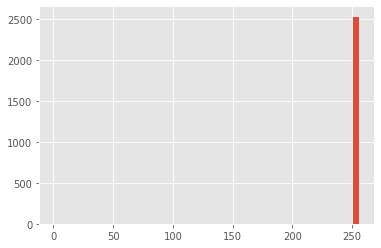

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 256

# X = [[word2idx[w[0]] for w in s] for s in sentences]
# X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

# y = [[tag2idx[w[2]] for w in s] for s in sentences]
# y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

x_train = [[word2idx[w[0]] for w in s] for s in sentences_train]
x_train = pad_sequences(maxlen=max_len, sequences=x_train, padding="post", value=num_words-1)

x_test = [[word2idx[w[0]] for w in s] for s in sentences_test]
x_test = pad_sequences(maxlen=max_len, sequences=x_test, padding="post", value=num_words-1)

x_val = [[word2idx[w[0]] for w in s] for s in sentences_val]
x_val = pad_sequences(maxlen=max_len, sequences=x_val, padding="post", value=num_words-1)

y_train = [[tag2idx[w[2]] for w in s] for s in sentences_train]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx_train["O"])

y_test = [[tag2idx[w[2]] for w in s] for s in sentences_test]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx_test["O"])

y_val = [[tag2idx[w[2]] for w in s] for s in sentences_val]
y_val = pad_sequences(maxlen=max_len, sequences=y_val, padding="post", value=tag2idx_val["O"])

In [ ]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Rede Neural: Bi-LSTM

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
# lowercase
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 50)           1330200   
                                                                 
 spatial_dropout1d (SpatialD  (None, 256, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256, 200)         120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 256, 4)           804       
 ibuted)                                                         
                                                             

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Treinamento do modelo

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

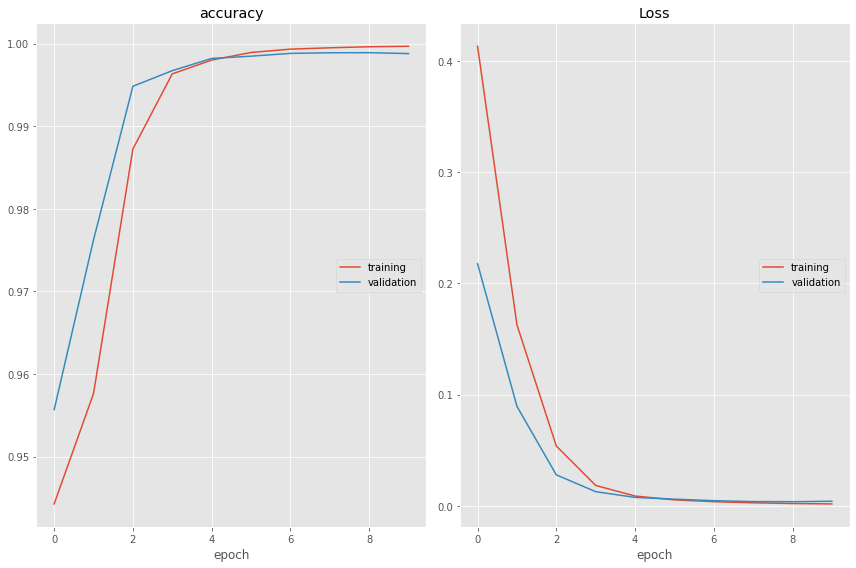

accuracy
	training         	 (min:    0.944, max:    1.000, cur:    1.000)
	validation       	 (min:    0.956, max:    0.999, cur:    0.999)
Loss
	training         	 (min:    0.002, max:    0.413, cur:    0.002)
	validation       	 (min:    0.004, max:    0.218, cur:    0.004)

Epoch 00010: val_loss did not improve from 0.00362
60/60 [==============================] - 55s 920ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0040 - val_accuracy: 0.9988
CPU times: user 16min 55s, sys: 43.4 s, total: 17min 39s
Wall time: 9min 13s


In [ ]:
%%time

chkpt = ModelCheckpoint("model_weights_comecoefim_v3_256.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]#, F1Metrics(idx2tag)]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

### Avaliação do modelo e funções de inferência

In [ ]:
model.evaluate(x_val, y_val)

10/10 [==============================] - 1s 119ms/step - loss: 0.0038 - accuracy: 0.9990


[0.003763139946386218, 0.9989863634109497]

In [ ]:
y_pred_lstm = model.predict(x_val, batch_size=32, verbose=2)
# explicação shape: (instâncias, palavras em cada instância(max_len), prob de cada label)
y_pred_lstm.shape

10/10 - 2s - 2s/epoch - 160ms/step


(316, 256, 4)

In [ ]:
y_val.shape

(316, 256)

In [ ]:
index_array = np.argmax(y_pred_lstm, axis=-1)
index_array.shape

(316, 256)

#### F1-Score com Seqeval

In [ ]:
!pip install seqeval

In [ ]:
from seqeval.metrics import f1_score, classification_report

In [ ]:
# para usar no seqeval
idx2tag = {v: k for k, v in tag2idx.items()}
idx2tag

{0: 'B-FIM', 1: 'I-Inicio', 2: 'O', 3: 'B-Inicio'}

In [ ]:
# seqeval pede listas de listas de strings como entrada.
# esse pós-processamento mapeia os labels inteiros com suas
# respectivas strings. É importante montar listas para atos
# e fazer append dessas listas com a lista externa depois.
# SÓ FUNCIONA DESSE JEITO!
def numpy_to_seqeval(y_true, y_pred):
  '''
    Parameters:
    y_true: labels verdadeiros (num_atos, max_len)
    y_pred: saída do model.predict com argmax axis=-1 (num_atos, max_len)

    Returns:
    ground_truth: lista de listas com strings de cada tag para
    os labels verdadeiros
    tags_preditas: lista de listas com strings de cada tag para
    os labels preditos
  '''
  tags_preditas = []
  ground_truth = []
  for ato in y_pred:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(idx2tag[palavra])
    tags_preditas.append(tags_ato)

  for ato in y_true:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(idx2tag[palavra])
    ground_truth.append(tags_ato)
  
  return ground_truth, tags_preditas

In [ ]:
agora, foi = numpy_to_seqeval(y_val, index_array)

In [ ]:
f1_score(agora, foi)

0.9829365915314935

In [ ]:
print(classification_report(agora, foi))

              precision    recall  f1-score   support

         FIM       0.99      0.98      0.99      1190
      Inicio       0.98      0.97      0.98      1192

   micro avg       0.99      0.98      0.98      2382
   macro avg       0.99      0.98      0.98      2382
weighted avg       0.99      0.98      0.98      2382



#### Função de inferência - Segmentação

In [ ]:
tag2idx

{'B-FIM': 1, 'B-Inicio': 3, 'I-Inicio': 0, 'O': 2}

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def passito_passito(texto, max_len):
    texto_tokenizado = word_tokenize(texto)
    # print(f'Qtd de tokens no texto dado: {len(texto_tokenizado)}')
    trechos = []
    if len(texto_tokenizado) > max_len:
        num_listas = len(texto_tokenizado) // max_len
        idx_tokens_restantes = num_listas*max_len
        inicio = 0
        for num in range(num_listas):
            fim = (num+1)*max_len
            lista = texto_tokenizado[inicio:fim]
            inicio = (num+1)*max_len
            trechos.append(lista)
            if num == num_listas-1:
                lista = texto_tokenizado[idx_tokens_restantes:]
                trechos.append(lista)
    else:
        trechos.append(texto_tokenizado)
    return trechos

In [ ]:
def get_preds(texto, modelo, max_len, word2idx, idx2tag):
    trechos = passito_passito(texto, 256)
    preds_final = []
    texto_tok_final = []

    for trecho in trechos:
        print(f'Qtd de tokens no texto dado: {len(trecho)}')
        # print(trecho)
        index_textos = []
        for word in trecho:
            if word in word2idx.keys():
                index_textos.append(word2idx[word])
            else:
                index_textos.append(word2idx['UNK'])
        index_textos = pad_sequences(maxlen=max_len, sequences=[index_textos], padding='post', value=len(word2idx)-1)
        index_textos = np.array(index_textos)
        pred = modelo.predict(index_textos)
        pred = np.argmax(pred, axis=-1)
        for token, rotulo in zip(trecho, pred[0]):
            texto_tok_final.append(token)
            preds_final.append(idx2tag[rotulo])

        # for token, tag in zip(trecho, pred[0]):
        #     print(f'{token}\t {idx2tag[tag]}')

    return texto_tok_final, preds_final

In [ ]:
exemplo = 'EXONERAR SANDRA BARBOSA DE ARAÚJO do Cargo de Natureza Especial, Símbolo CNE-07, SIGRH 05002782, de Assessor Especial, do Gabinete, do Gabinete do Vice-Governador. NOMEAR THAIS OLIVEIRA, Farmacêutico Bioquímico-Farmácia, matrícula 17043700, para exercer o Cargo Público em Comissão, Símbolo CPC-08, SIGRH 55004987, de Gerente, da Gerência de Armazenamento e Distribuição de Medicamentos e Materiais Laboratoriais, da Diretoria de Logística, da Subsecretaria de Logística em Saúde, da Secretaria de Estado de Saúde do Distrito Federal.'
texto_tok_final, preds_final = get_preds(exemplo, model, 256, word2idx, idx2tag)

Qtd de tokens no texto dado: 90
EXONERAR	 B-Inicio
SANDRA	 I-Inicio
BARBOSA	 O
DE	 O
ARAÚJO	 O
do	 O
Cargo	 O
de	 O
Natureza	 O
Especial	 O
,	 O
Símbolo	 O
CNE-07	 O
,	 O
SIGRH	 O
05002782	 O
,	 O
de	 O
Assessor	 O
Especial	 O
,	 O
do	 O
Gabinete	 O
,	 O
do	 O
Gabinete	 O
do	 O
Vice-Governador	 O
.	 B-FIM
NOMEAR	 B-Inicio
THAIS	 I-Inicio
OLIVEIRA	 O
,	 O
Farmacêutico	 O
Bioquímico-Farmácia	 O
,	 O
matrícula	 O
17043700	 O
,	 O
para	 O
exercer	 O
o	 O
Cargo	 O
Público	 O
em	 O
Comissão	 O
,	 O
Símbolo	 O
CPC-08	 O
,	 O
SIGRH	 O
55004987	 O
,	 O
de	 O
Gerente	 O
,	 O
da	 O
Gerência	 O
de	 O
Armazenamento	 O
e	 O
Distribuição	 O
de	 O
Medicamentos	 O
e	 O
Materiais	 O
Laboratoriais	 O
,	 O
da	 O
Diretoria	 O
de	 O
Logística	 O
,	 O
da	 O
Subsecretaria	 O
de	 O
Logística	 O
em	 O
Saúde	 O
,	 O
da	 O
Secretaria	 O
de	 O
Estado	 O
de	 O
Saúde	 O
do	 O
Distrito	 O
Federal	 O
.	 O


In [ ]:
len(texto_tok_final), len(preds_final)

(90, 90)

In [ ]:
enderecos = encontrar_fronteiras(texto_tok_final, preds_final)

idx 0, token EXONERAR
idx 29, token NOMEAR


In [ ]:
def encontrar_fronteiras(texto_tok_final, preds_final):
    inicio = False
    fim = False
    enderecos = []
    for idx, tag in enumerate(preds_final):
        # print(f'{idx, tag}')
        if tag == 'B-Inicio':
            inicio = idx
            # print(f'idx {idx}, token {texto_tok_final[idx]}')
        elif tag == 'B-FIM':
            # se já tem inicio, seta o fim
            if inicio is not False:
                # se tem início e o fim vem depois
                if idx > inicio:
                    fim = idx
                else:
                    fim = False
            else:
                fim = False
        if inicio is not False and fim is not False:
            enderecos.append([inicio, fim])
            inicio = False
            fim = False
    
    if inicio is not False and fim is False:
        enderecos.append([inicio, len(preds_final)])            
    
    return enderecos

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [ ]:
def strings_finais(enderecos, texto_tok_final):
    detokenizador = TreebankWordDetokenizer()
    atos_encontrados = []
    for endereco in enderecos:
        if endereco[1] + 1 > len(texto_tok_final):
            string_segmentada = detokenizador.detokenize(texto_tok_final[endereco[0]:endereco[1]])
        else:
            string_segmentada = detokenizador.detokenize(texto_tok_final[endereco[0]:endereco[1]+1])
        atos_encontrados.append(string_segmentada)
    
    return atos_encontrados

In [ ]:
strings_finais(enderecos, texto_tok_final)

['EXONERAR SANDRA BARBOSA DE ARAÚJO do Cargo de Natureza Especial, Símbolo CNE-07, SIGRH 05002782, de Assessor Especial, do Gabinete, do Gabinete do Vice-Governador.',
 'NOMEAR THAIS OLIVEIRA, Farmacêutico Bioquímico-Farmácia, matrícula 17043700, para exercer o Cargo Público em Comissão, Símbolo CPC-08, SIGRH 55004987, de Gerente, da Gerência de Armazenamento e Distribuição de Medicamentos e Materiais Laboratoriais, da Diretoria de Logística, da Subsecretaria de Logística em Saúde, da Secretaria de Estado de Saúde do Distrito Federal.']

In [ ]:
def segmentacao(texto, modelo, max_len, word2idx, idx2tag):
    texto_tok_final, preds_final = get_preds(texto, modelo, max_len, word2idx, idx2tag)
    enderecos = encontrar_fronteiras(texto_tok_final, preds_final)
    atos_encontrados = strings_finais(enderecos, texto_tok_final)

    return(atos_encontrados)

In [ ]:
exemplo = 'EXONERAR SANDRA BARBOSA DE ARAÚJO do Cargo de Natureza Especial, Símbolo CNE-07, SIGRH 05002782, de Assessor Especial, do Gabinete, do Gabinete do Vice-Governador. NOMEAR THAIS OLIVEIRA, Farmacêutico Bioquímico-Farmácia, matrícula 17043700, para exercer o Cargo Público em Comissão, Símbolo CPC-08, SIGRH 55004987, de Gerente, da Gerência de Armazenamento e Distribuição de Medicamentos e Materiais Laboratoriais, da Diretoria de Logística, da Subsecretaria de Logística em Saúde, da Secretaria de Estado de Saúde do Distrito Federal.'
segmentacao(exemplo, model, 256, word2idx, idx2tag)

Qtd de tokens no texto dado: 90


['EXONERAR SANDRA BARBOSA DE ARAÚJO do Cargo de Natureza Especial, Símbolo CNE-07, SIGRH 05002782, de Assessor Especial, do Gabinete, do Gabinete do Vice-Governador.',
 'NOMEAR THAIS OLIVEIRA, Farmacêutico Bioquímico-Farmácia, matrícula 17043700, para exercer o Cargo Público em Comissão, Símbolo CPC-08, SIGRH 55004987, de Gerente, da Gerência de Armazenamento e Distribuição de Medicamentos e Materiais Laboratoriais, da Diretoria de Logística, da Subsecretaria de Logística em Saúde, da Secretaria de Estado de Saúde do Distrito Federal.']

Texto abaixo: Página 15, https://dodf.df.gov.br/index/visualizar-arquivo/?pasta=2022|01_Janeiro|DODF%20010%2014-01-2022|&arquivo=DODF%20010%2014-01-2022%20INTEGRA.pdf

In [ ]:
ola = 'EXONERAR, por estar sendo nomeado para outro cargo, ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, do Cargo Público em Comissão, Símbolo CPC-01, SIGRH 55003416, de Chefe, do Núcleo de Gestão de Pessoas das Unidades de Atenção Especializada no Guará, da Gerência de Pessoas das Unidades de Atenção Especializada da Região Centro-Sul, da Diretoria Administrativa, da Superintendência Regional de Saúde Centro-Sul, da Secretaria de Estado de Saúde do Distrito Federal. EXONERAR KELLY DE SOUSA SILVA, Administradora, matrícula 14427869, do Cargo Público de Natureza Especial, Símbolo CPE-06, SIGRH 55005524, de Coordenador, da Coordenação de Administração de Profissionais, da Subsecretaria de Gestão de Pessoas, da Secretaria de Estado de Saúde do Distrito Federal. NOMEAR ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, para exercer o Cargo Público de Natureza Especial, Símbolo CPE-06, SIGRH 55005524, de Coordenador, da Coordenação de Administração de Profissionais, da Subsecretaria de Gestão de Pessoas, da Secretaria de Saúde do Distrito Federal. EXONERAR, por estar sendo nomeada para outro cargo, ZAYANA SILVA DE CASTRO PIRES MENEZES, Administradora, matrícula 14405741, do Cargo Público em Comissão, Símbolo CPC-04, SIGRH 55005588, de Assessor Técnico, da Superintendência da Região de Saúde Centro-Sul, da Secretaria de Estado de Saúde do Distrito Federal. EXONERAR FLÁVIA MACHADO DE SOUZA CABRAL, Analista em Gestão e Assistência Pública à Saúde, matrícula 14433273, do Cargo Público de Natureza Especial, Símbolo CPE-07, SIGRH 55005243, de Assessor Especial, da Subsecretaria de Gestão de Pessoas, da Secretaria de Estado de Saúde do Distrito Federal.'
segmentacao(ola, model, 256, word2idx, idx2tag)

Qtd de tokens no texto dado: 256
Qtd de tokens no texto dado: 54


['EXONERAR, por estar sendo nomeado para outro cargo, ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, do Cargo Público em Comissão, Símbolo CPC-01, SIGRH 55003416, de Chefe, do Núcleo de Gestão de Pessoas das Unidades de Atenção Especializada no Guará, da Gerência de Pessoas das Unidades de Atenção Especializada da Região Centro-Sul, da Diretoria Administrativa, da Superintendência Regional de Saúde Centro-Sul, da Secretaria de Estado de Saúde do Distrito Federal.',
 'EXONERAR KELLY DE SOUSA SILVA, Administradora, matrícula 14427869, do Cargo Público de Natureza Especial, Símbolo CPE-06, SIGRH 55005524, de Coordenador, da Coordenação de Administração de Profissionais, da Subsecretaria de Gestão de Pessoas, da Secretaria de Estado de Saúde do Distrito Federal.',
 'NOMEAR ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, para exercer o Cargo Público de Natureza Especial, Símbolo CPE-

In [ ]:
hey = 'O VICE-GOVERNADOR NO EXERCÍCIO DO CARGO DE GOVERNADOR DO DISTRITO FEDERAL, com fundamento no artigo 92, e no uso das atribuições que lhe conferem os incisos XXVI e XXVII, do artigo 100, da Lei Orgânica do Distrito Federal, resolve: EXONERAR, por estar sendo nomeado para outro cargo, ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, do Cargo Público em Comissão, Símbolo CPC-01, SIGRH 55003416, de Chefe, do Núcleo de Gestão de Pessoas das Unidades de Atenção Especializada no Guará, da Gerência de Pessoas das Unidades de Atenção Especializada da Região Centro-Sul, da Diretoria Administrativa, da Superintendência Regional de Saúde Centro-Sul, da Secretaria de Estado de Saúde do Distrito Federal. EXONERAR KELLY DE SOUSA SILVA, Administradora, matrícula 14427869, do Cargo Público de Natureza Especial, Símbolo CPE-06, SIGRH 55005524, de Coordenador, da Coordenação de Administração de Profissionais, da Subsecretaria de Gestão de Pessoas, da Secretaria de Estado de Saúde do Distrito Federal. NOMEAR ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, para exercer o Cargo Público de Natureza Especial, Símbolo CPE-06, SIGRH 55005524, de Coordenador, da Coordenação de Administração de Profissionais, da Subsecretaria de Gestão de Pessoas, da Secretaria de Saúde do Distrito Federal. EXONERAR, por estar sendo nomeada para outro cargo, ZAYANA SILVA DE CASTRO PIRES MENEZES, Administradora, matrícula 14405741, do Cargo Público em Comissão, Símbolo CPC-04, SIGRH 55005588, de Assessor Técnico, da Superintendência da Região de Saúde Centro-Sul, da Secretaria de Estado de Saúde do Distrito Federal. EXONERAR FLÁVIA MACHADO DE SOUZA CABRAL, Analista em Gestão e Assistência Pública à Saúde, matrícula 14433273, do Cargo Público de Natureza Especial, Símbolo CPE-07, SIGRH 55005243, de Assessor Especial, da Subsecretaria de Gestão de Pessoas, da Secretaria de Estado de Saúde do Distrito Federal.'
segmentacao(hey, model, 256, word2idx, idx2tag)

Qtd de tokens no texto dado: 256
Qtd de tokens no texto dado: 99


['EXONERAR, por estar sendo nomeado para outro cargo, ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, do Cargo Público em Comissão, Símbolo CPC-01, SIGRH 55003416, de Chefe, do Núcleo de Gestão de Pessoas das Unidades de Atenção Especializada no Guará, da Gerência de Pessoas das Unidades de Atenção Especializada da Região Centro-Sul, da Diretoria Administrativa, da Superintendência Regional de Saúde Centro-Sul, da Secretaria de Estado de Saúde do Distrito Federal.',
 'EXONERAR KELLY DE SOUSA SILVA, Administradora, matrícula 14427869, do Cargo Público de Natureza Especial, Símbolo CPE-06, SIGRH 55005524, de Coordenador, da Coordenação de Administração de Profissionais, da Subsecretaria de Gestão de Pessoas, da Secretaria de Estado de Saúde do Distrito Federal.',
 'NOMEAR ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, para exercer o Cargo Público de Natureza Especial, Símbolo CPE-

In [ ]:
with open('word2idx_funcional.pkl', 'wb') as f:
  pkl.dump(word2idx, f)

with open('idx2tag_funcional.pkl', 'wb') as f:
  pkl.dump(tag2idx, f)

## Classificação de textos

### Separação dos dados

In [ ]:
df = pd.read_csv('/content/dodf_atos_pessoal_v3.csv')
df_atos = df.loc[df['tipo_ent'].str.contains('Ato_')]
df_atos = df_atos.reset_index(drop=True)
df_atos_usab = df_atos.loc[df_atos['id_dodf'] != ('44_175.10.9.2015' or '63_191.20.9.2012' or '29_200.24.9.2014' or '21_139.10.7.2014')]
df_atos_usab = df_atos_usab.reset_index(drop=True)

In [ ]:
possible_labels = df_atos_usab.tipo_ent.unique()
label_dict = {}
for index, label in enumerate(possible_labels):
    label_dict[label] = index
num2label = {v: k for k, v in label_dict.items()}

In [ ]:
df_atos_usab['label_int'] = df_atos_usab.tipo_ent.replace(label_dict)
df_atos_cls = df_atos_usab.drop(['id_ato', 'id_dodf', 'num_doc_dodf', 'data_doc_dodf',
              'tipo_rel', 'id_rel', 'anotador_rel', 'texto_rel', 'id_ent', 'anotador_ent'], axis=1)
df_atos_cls

In [ ]:
from sklearn.model_selection import train_test_split

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(df_atos_cls['texto_ent'],
                                                                    df_atos_cls['label_int'],
                                                                    test_size=0.25, 
                                                                    random_state=14, 
                                                                    stratify=df_atos_cls['label_int'],)

# X_test_cls, X_val_cls, y_test_cls, y_val_cls = train_test_split(X_test_cls, y_test_cls, test_size=0.5,
#                                                 random_state=14, stratify=y_test_cls)

### Caracterização TF-IDF e classificação com SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# fit_transform no treino
X_csr_train = vectorizer.fit_transform(X_train_cls)
print(X_csr_train.shape)

# apenas transform no teste
X_csr_test = vectorizer.transform(X_test_cls)
print(X_csr_test.shape)

(7226, 12076)
(2409, 12076)


In [ ]:
svm_model = LinearSVC(max_iter=1000, random_state=14, verbose=True)
svm_model.fit(X_csr_train, y_train_cls)
svm_prediction_tfidf = svm_model.predict(X_csr_test)

[LibLinear]

In [ ]:
results = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'support']
          )
results.loc['TF-IDF + SVM'] = precision_recall_fscore_support(
          y_test_cls, 
          svm_prediction_tfidf, 
          average = 'weighted'
          )

In [ ]:
results

,Precision,Recall,F1 score,support
TF-IDF + SVM,0.991891,0.991698,0.991193,NaN


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_cls, svm_prediction_tfidf, target_names=possible_labels))

                                precision    recall  f1-score   support

              Ato_Substituicao       1.00      1.00      1.00       601
         Ato_Abono_Permanencia       1.00      1.00      1.00        34
       Ato_Retificacao_Efetivo       0.96      0.99      0.98       310
                    Ato_Cessao       0.99      1.00      0.99        66
                  Ato_Reversao       1.00      1.00      1.00        15
   Ato_Exoneracao_Comissionado       1.00      1.00      1.00       594
Ato_Tornado_Sem_Efeito_Exo_Nom       0.97      1.00      0.98        62
     Ato_Nomeacao_Comissionado       1.00      1.00      1.00       577
  Ato_Retificacao_Comissionado       1.00      0.78      0.88        50
    Ato_Tornado_Sem_Efeito_Apo       1.00      0.40      0.57         5
        Ato_Exoneracao_Efetivo       1.00      0.97      0.99        76
          Ato_Nomeacao_Efetivo       1.00      0.95      0.97        19

                      accuracy                           0.99 

In [ ]:
# https://stackoverflow.com/questions/60860121/plotly-how-to-make-an-annotated-confusion-matrix-using-a-heatmap
def plot_cm_plotly(matriz_confusao, classes):
  import plotly.figure_factory as ff
  cm_list = matriz_confusao.tolist()
  classes_list = classes.tolist()

  z = cm_list

  # invert z idx values
  z = z[::-1]

  x = classes_list
  y = x[::-1].copy() # invert idx values of x

  # change each element of z to type string for annotations
  z_text = [[str(y) for y in x] for x in z]

  # set up figure 
  fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  # add title
  fig.update_layout(title_text='<i><b>Confusion\nmatrix</b></i>',
                    #xaxis = dict(title='x'),
                    #yaxis = dict(title='x')
                  )

  # add custom xaxis title
  fig.add_annotation(dict(font=dict(color="black",size=14),
                          x=0.5,
                          y=-0.15,
                          showarrow=False,
                          text="Predicted value",
                          xref="paper",
                          yref="paper"))

  # add custom yaxis title
  fig.add_annotation(dict(font=dict(color="black",size=14),
                          x=-0.35,
                          y=0.5,
                          showarrow=False,
                          text="Real value",
                          textangle=-90,
                          xref="paper",
                          yref="paper"))

  # adjust margins to make room for yaxis title
  fig.update_layout(margin=dict(t=50, l=200))

  # add colorbar
  fig['data'][0]['showscale'] = True
  fig.show()

In [ ]:
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(y_test_cls, svm_prediction_tfidf)
classes = [num2label.get(item,item) for item in svm_model.classes_]

# Plot non-normalized confusion matrix
plot_cm_plotly(con_matrix, classes=np.array(classes))

In [ ]:
def predicao_cls(texto, modelo, vectorizer, map_int_label):
    texto_csr = vectorizer.transform([texto])
    predicao = int(modelo.predict(texto_csr))
    classe = map_int_label[predicao]
    
    return classe
    # print(f'O texto {texto}\n é da classe {classe}.')

In [ ]:
with open('modelo_cls_svm_v3.pkl', 'wb') as f:
    pkl.dump(svm_model, f)

with open('num2label_cls_v3.pkl', 'wb') as f:
    pkl.dump(num2label, f)

## Conjunção NER/Classificação

In [ ]:
def segmentar_e_classificar(lista_seg, model_cls, vectorizer, num2label):
    df_ato_label = pd.DataFrame(columns=['Texto ato', 'Rótulo'])
    lista_linhas = []
    for ato in lista_seg:
        classe = predicao_cls(ato, model_cls, vectorizer, num2label)
        dict_linha = {
            'Texto ato': ato,
            'Rótulo': classe
        }
        lista_linhas.append(dict_linha)
    df_ato_label = pd.DataFrame(lista_linhas)

    return df_ato_label

In [ ]:
hey = 'O VICE-GOVERNADOR NO EXERCÍCIO DO CARGO DE GOVERNADOR DO DISTRITO FEDERAL, com fundamento no artigo 92, e no uso das atribuições que lhe conferem os incisos XXVI e XXVII, do artigo 100, da Lei Orgânica do Distrito Federal, resolve: EXONERAR, por estar sendo nomeado para outro cargo, ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, do Cargo Público em Comissão, Símbolo CPC-01, SIGRH 55003416, de Chefe, do Núcleo de Gestão de Pessoas das Unidades de Atenção Especializada no Guará, da Gerência de Pessoas das Unidades de Atenção Especializada da Região Centro-Sul, da Diretoria Administrativa, da Superintendência Regional de Saúde Centro-Sul, da Secretaria de Estado de Saúde do Distrito Federal. EXONERAR KELLY DE SOUSA SILVA, Administradora, matrícula 14427869, do Cargo Público de Natureza Especial, Símbolo CPE-06, SIGRH 55005524, de Coordenador, da Coordenação de Administração de Profissionais, da Subsecretaria de Gestão de Pessoas, da Secretaria de Estado de Saúde do Distrito Federal. NOMEAR ADILSON ALVES DE CASTRO JÚNIOR, Analista em Gestão e Assistência Pública à Saúde, matrícula 01294873, para exercer o Cargo Público de Natureza Especial, Símbolo CPE-06, SIGRH 55005524, de Coordenador, da Coordenação de Administração de Profissionais, da Subsecretaria de Gestão de Pessoas, da Secretaria de Saúde do Distrito Federal. EXONERAR, por estar sendo nomeada para outro cargo, ZAYANA SILVA DE CASTRO PIRES MENEZES, Administradora, matrícula 14405741, do Cargo Público em Comissão, Símbolo CPC-04, SIGRH 55005588, de Assessor Técnico, da Superintendência da Região de Saúde Centro-Sul, da Secretaria de Estado de Saúde do Distrito Federal. EXONERAR FLÁVIA MACHADO DE SOUZA CABRAL, Analista em Gestão e Assistência Pública à Saúde, matrícula 14433273, do Cargo Público de Natureza Especial, Símbolo CPE-07, SIGRH 55005243, de Assessor Especial, da Subsecretaria de Gestão de Pessoas, da Secretaria de Estado de Saúde do Distrito Federal.'

In [ ]:
atos = segmentacao(hey, model, 256, word2idx, idx2tag)
segmentar_e_classificar(atos, svm_model, vectorizer, num2label)

Qtd de tokens no texto dado: 256
Qtd de tokens no texto dado: 99


,Texto ato,Rótulo
0,"EXONERAR, por estar sendo nomeado para outro c...",Ato_Exoneracao_Comissionado
1,"EXONERAR KELLY DE SOUSA SILVA, Administradora,...",Ato_Exoneracao_Comissionado
2,"NOMEAR ADILSON ALVES DE CASTRO JÚNIOR, Analist...",Ato_Nomeacao_Comissionado
3,"EXONERAR, por estar sendo nomeada para outro c...",Ato_Exoneracao_Comissionado
4,"EXONERAR FLÁVIA MACHADO DE SOUZA CABRAL, Anali...",Ato_Exoneracao_Comissionado
